In [135]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [136]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [137]:
import mysql.connector
import json
import pandas as pd
import datetime


mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="Kaja25802580",
  database="twitter_database"
)

mycursor = mydb.cursor()


In [138]:
df_tweets = pd.read_sql("select id, tweet_text from tweets where like_count > 100", mydb)

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
df_tweets['compound'] = df_tweets['tweet_text'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df_tweets['label'] = -1
# -1 -> negative
# 0 -> neutral
# 1 -> positive
for ind in df_tweets.index:
    if df_tweets['compound'][ind] < -0.05:
        df_tweets['label'][ind] = 0
    elif df_tweets['compound'][ind] > 0.05:
        df_tweets['label'][ind] = 1
    else:
        df_tweets['label'][ind] = -1
df_tweets.drop(df_tweets.index[df_tweets['label'] == -1], inplace=True)
del df_tweets['compound']

sentiment_df_tweets = pd.DataFrame(df_tweets.groupby('label').size())
sentiment_df_tweets

,0
label,
0,3342
1,5561


In [141]:

train_df, test_df = train_test_split(df_tweets, test_size=0.2)

In [142]:
del test_df['label']


In [143]:
test_df

,id,tweet_text
4476,1271479973208035328,Having a safe and effective COVID-19 vaccine a...
6005,1296097429973012482,Pope Francis said during his general audience ...
7547,1318504503335919616,"In a world first for COVID-19, young healthy v..."
939,1242130217436577792,ANNOUNCEMENT: The PM has announced $12 million...
2379,1253421698138771457,"Ultimately, Covid-19 vaccine expectations may ..."
...,...,...
5718,1292450764087005185,⚠️~40% of people infected with #coronavirus ne...
1640,1247935734218178563,Duterte reiterates that the solution to COVID ...
4076,1267544794571649024,"When we hear about Nigeria's 10,000 COVID-19 c..."
4954,1276844083235876865,Ffs this is not “improbable.” It’s 3 overconfi...


In [144]:
combine = train_df.append(test_df,ignore_index=True,sort=True)
combine

,id,label,tweet_text
0,1244308224636944384,0.0,What people don't get yet is that the #Coronav...
1,1340340405448151048,0.0,For the Black Americans who are skeptical of t...
2,1251914062067310593,1.0,China now has 3 #COVID__19 Vaccine Candidates ...
3,1259052605356929025,1.0,Government: universities are a bunch of leftie...
4,1330132042705760259,0.0,I am baffled by low update of free child flu n...
...,...,...,...
8898,1292450764087005185,NaN,⚠️~40% of people infected with #coronavirus ne...
8899,1247935734218178563,NaN,Duterte reiterates that the solution to COVID ...
8900,1267544794571649024,NaN,"When we hear about Nigeria's 10,000 COVID-19 c..."
8901,1276844083235876865,NaN,Ffs this is not “improbable.” It’s 3 overconfi...


In [145]:
#usuwanie tweetow z @
def remove_pattern(text, pattern):
    r = re.findall(pattern, text)    
    # re.sub() removes @
    for i in r:
        text = re.sub(i, "", text)    
    return text


In [146]:
combine['tidy_tweets'] = np.vectorize(remove_pattern)(combine['tweet_text'], "@[\w]*")
combine.head()

,id,label,tweet_text,tidy_tweets
0,1244308224636944384,0.0,What people don't get yet is that the #Coronav...,What people don't get yet is that the #Coronav...
1,1340340405448151048,0.0,For the Black Americans who are skeptical of t...,For the Black Americans who are skeptical of t...
2,1251914062067310593,1.0,China now has 3 #COVID__19 Vaccine Candidates ...,China now has 3 #COVID__19 Vaccine Candidates ...
3,1259052605356929025,1.0,Government: universities are a bunch of leftie...,Government: universities are a bunch of leftie...
4,1330132042705760259,0.0,I am baffled by low update of free child flu n...,I am baffled by low update of free child flu n...


In [147]:
#Removing Punctuations, Numbers, and Special Characters
combine['tidy_tweets'] = combine['tidy_tweets'].str.replace("[^a-zA-Z#]", " ")
combine.head()

,id,label,tweet_text,tidy_tweets
0,1244308224636944384,0.0,What people don't get yet is that the #Coronav...,What people don t get yet is that the #Coronav...
1,1340340405448151048,0.0,For the Black Americans who are skeptical of t...,For the Black Americans who are skeptical of t...
2,1251914062067310593,1.0,China now has 3 #COVID__19 Vaccine Candidates ...,China now has #COVID Vaccine Candidates ...
3,1259052605356929025,1.0,Government: universities are a bunch of leftie...,Government universities are a bunch of leftie...
4,1330132042705760259,0.0,I am baffled by low update of free child flu n...,I am baffled by low update of free child flu n...


In [148]:
#Removing Short Words
combine['tidy_tweets'] = combine['tidy_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combine.head()


,id,label,tweet_text,tidy_tweets
0,1244308224636944384,0.0,What people don't get yet is that the #Coronav...,What people that #CoronavirusPandemic over wee...
1,1340340405448151048,0.0,For the Black Americans who are skeptical of t...,Black Americans skeptical coronavirus vaccine ...
2,1251914062067310593,1.0,China now has 3 #COVID__19 Vaccine Candidates ...,China #COVID Vaccine Candidates them being dev...
3,1259052605356929025,1.0,Government: universities are a bunch of leftie...,Government universities bunch lefties drain pu...
4,1330132042705760259,0.0,I am baffled by low update of free child flu n...,baffled update free child nasal vaccine have a...


In [149]:
#Tokenizacja
tokenized_tweet = combine['tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()


0    [What, people, that, #CoronavirusPandemic, ove...
1    [Black, Americans, skeptical, coronavirus, vac...
2    [China, #COVID, Vaccine, Candidates, them, bei...
3    [Government, universities, bunch, lefties, dra...
4    [baffled, update, free, child, nasal, vaccine,...
Name: tidy_tweets, dtype: object

In [150]:
#Stemming
from nltk import PorterStemmer

ps = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])
tokenized_tweet.head()


0    [what, peopl, that, #coronaviruspandem, over, ...
1    [black, american, skeptic, coronaviru, vaccin,...
2    [china, #covid, vaccin, candid, them, be, deve...
3    [govern, univers, bunch, lefti, drain, public,...
4    [baffl, updat, free, child, nasal, vaccin, hav...
Name: tidy_tweets, dtype: object

In [151]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['tidy_tweets'] = tokenized_tweet
combine.head()

,id,label,tweet_text,tidy_tweets
0,1244308224636944384,0.0,What people don't get yet is that the #Coronav...,what peopl that #coronaviruspandem over week m...
1,1340340405448151048,0.0,For the Black Americans who are skeptical of t...,black american skeptic coronaviru vaccin stori...
2,1251914062067310593,1.0,China now has 3 #COVID__19 Vaccine Candidates ...,china #covid vaccin candid them be develop int...
3,1259052605356929025,1.0,Government: universities are a bunch of leftie...,govern univers bunch lefti drain public purs g...
4,1330132042705760259,0.0,I am baffled by low update of free child flu n...,baffl updat free child nasal vaccin have abund...


In [152]:
#WordCloud
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests


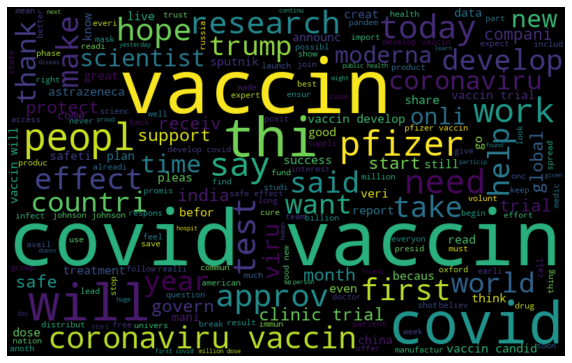

In [153]:
#POZYTYWNE
words_positive = ' '.join(text for text in combine['tidy_tweets'][combine['label'] == 1])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words_positive)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

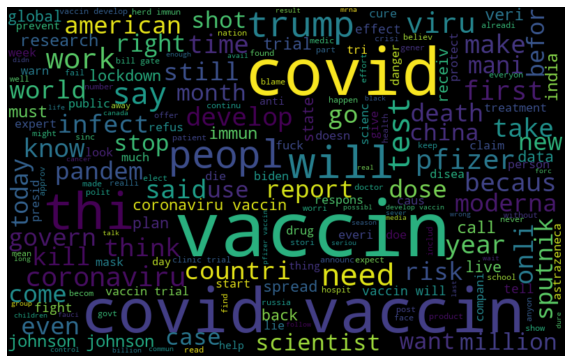

In [154]:
#NEGATYWNE
words_negative = ' '.join(text for text in combine['tidy_tweets'][combine['label'] == 0])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words_negative)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## HASZTAGI

In [155]:
def Hashtags_Extract(x):
    hashtags=[]
    
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

In [156]:
#POZYTYWNE
h_positive = Hashtags_Extract(combine['tidy_tweets'][combine['label'] == 1])
h_positive_unnest = sum(h_positive,[])

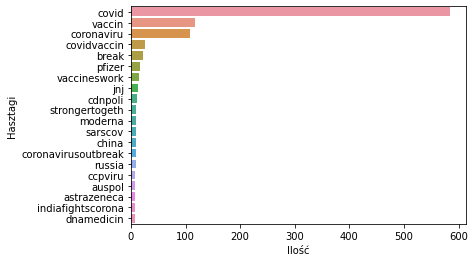

In [157]:
word_freq_positive = nltk.FreqDist(h_positive_unnest)
df_positive = pd.DataFrame({'Hasztagi':list(word_freq_positive.keys()),'Ilość':list(word_freq_positive.values())})
df_positive_plot = df_positive.nlargest(20,columns='Ilość') 
sns_plot = sns.barplot(data=df_positive_plot,y='Hasztagi',x='Ilość')
sns_plot.figure.savefig('charts/positive_hash.png', dpi=150)




In [158]:
#NEGATYWNE
h_negative = Hashtags_Extract(combine['tidy_tweets'][combine['label'] == 0])
h_negative_unnest = sum(h_negative,[])

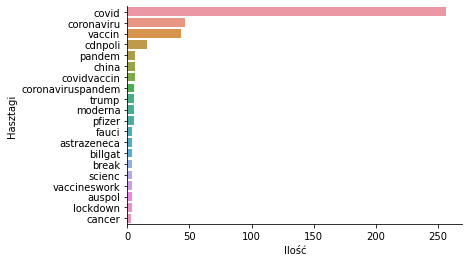

In [159]:
word_freq_negative = nltk.FreqDist(h_negative_unnest)
df_negative = pd.DataFrame({'Hasztagi':list(word_freq_negative.keys()),'Ilość':list(word_freq_negative.values())})
df_negative_plot = df_negative.nlargest(20,columns='Ilość') 
sns_plot = sns.barplot(data=df_negative_plot,y='Hasztagi',x='Ilość')
sns.despine()
sns_plot.figure.savefig('charts/negative_hash.png')


## Bag Of Words

In [160]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combine['tidy_tweets'])
df_bow = pd.DataFrame(bow.todense())
df_bow

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [161]:
from sklearn.model_selection import train_test_split

In [163]:
train_bow = bow[:7122] 
# test_bow = bow[4231:,:] 
x_train_bow,x_valid_bow,y_train_bow,y_valid_bow = train_test_split(train_bow, train_df['label'],test_size=0.3,random_state=2)

## DecisionTreeClassifier

In [164]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
model = DecisionTreeClassifier()
model.fit(x_train_bow, y_train_bow)

y_pred = model.predict_proba(x_valid_bow)
bow_DT_accuracy_v =  model.score(x_valid_bow, y_valid_bow)
bow_DT_accuracy_t =  model.score(x_train_bow, y_train_bow)

print("Training Accuracy :",bow_DT_accuracy_t )
print("Validation Accuracy :", bow_DT_accuracy_v)

# calculating the f1 score for the validation set
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
y_pred=y_pred[:,1]>=0.3

# converting the results to integer type
dct_int_bow=y_pred.astype(np.int)

# calculating f1 score
dct_score_bow=f1_score(y_valid_bow,dct_int_bow)

dct_score_bow

Training Accuracy : 0.999197592778335
Validation Accuracy : 0.6930276087973795


0.7641099855282198

## SVM

In [165]:
from sklearn import svm
clf = svm.SVC(probability=True)
clf.fit(x_train_bow, y_train_bow)

bow_svm_acc_v =  clf.score(x_valid_bow, y_valid_bow)
bow_svm_acc_t =  clf.score(x_train_bow, y_train_bow)

print("Training Accuracy :", bow_svm_acc_t)
print("Validation Accuracy :", bow_svm_acc_v)

y_pred = clf.predict_proba(x_valid_bow)
# calculating the f1 score for the validation set
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
y_pred=y_pred[:,1]>=0.3

# converting the results to integer type
svm_int_bow=y_pred.astype(np.int)

# calculating f1 score
svm_score_bow=f1_score(y_valid_bow,svm_int_bow)

svm_score_bow

Training Accuracy : 0.9364092276830491
Validation Accuracy : 0.7632194665418811


0.8197562540089802

## Naive Bayes

In [166]:
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()
gnb.fit(x_train_bow, y_train_bow)

bow_NB_acc_v = gnb.score(x_valid_bow, y_valid_bow)
bow_NB_acc_t = gnb.score(x_train_bow, y_train_bow)
print("Training Accuracy :", bow_NB_acc_t)
print("Validation Accuracy :", bow_NB_acc_v)

y_pred = gnb.predict_proba(x_valid_bow)
# calculating the f1 score for the validation set
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
y_pred=y_pred[:,1]>=0.3

# converting the results to integer type
gnb_int_bow=y_pred.astype(np.int)

# calculating f1 score
gnb_score_bow=f1_score(y_valid_bow,gnb_int_bow)

gnb_score_bow

Training Accuracy : 0.8136409227683049
Validation Accuracy : 0.7538605521759476


0.8198258539852645

## TfidfVectorizer

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(combine['tidy_tweets'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.463815


In [168]:
train_tfidf_matrix = tfidf_matrix[:7122]
x_train_tfidf,x_valid_tfidf,y_train_tfidf,y_valid_tfidf = train_test_split(train_tfidf_matrix,train_df['label'],test_size=0.3,random_state=17)

## DecisionTree

In [169]:
model.fit(x_train_tfidf,y_train_tfidf)
dct_tfidf = model.predict_proba(x_valid_tfidf)
dct_tfidf=dct_tfidf[:,1]>=0.3

TF_DT_acc_v = model.score(x_valid_tfidf, y_valid_tfidf)
TF_DT_acc_t = model.score(x_train_tfidf, y_train_tfidf)
print("Training Accuracy :",TF_DT_acc_t )
print("Validation Accuracy :", TF_DT_acc_v)

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf)

dct_score_tfidf

Training Accuracy : 0.9995987963891675
Validation Accuracy : 0.6911558259241928


0.7573529411764706

## SVM

In [170]:
clf.fit(x_train_tfidf,y_train_tfidf)
svm_tfidf = clf.predict_proba(x_valid_tfidf)
svm_tfidf=svm_tfidf[:,1]>=0.3

TF_SVM_acc_v = clf.score(x_valid_tfidf, y_valid_tfidf)
TF_SVM_acc_t = clf.score(x_train_tfidf, y_train_tfidf)
print("Training Accuracy :", TF_SVM_acc_t)
print("Validation Accuracy :", TF_SVM_acc_v)

# converting the results to integer type
svm_int_tfidf=svm_tfidf.astype(np.int)

# calculating f1 score
svm_score_tfidf=f1_score(y_valid_tfidf,svm_int_tfidf)

svm_score_tfidf

Training Accuracy : 0.9723169508525576
Validation Accuracy : 0.7716424894712214


0.8253652058432935


## Naive Bayes

In [171]:
gnb.fit(x_train_tfidf,y_train_tfidf)
gnb_tfidf = gnb.predict_proba(x_valid_tfidf)
gnb_tfidf=gnb_tfidf[:,1]>=0.3

TF_NB_acc_v = gnb.score(x_valid_tfidf, y_valid_tfidf)
TF_NB_acc_t = gnb.score(x_train_tfidf, y_train_tfidf)
print("Training Accuracy :",TF_NB_acc_t)
print("Validation Accuracy :", TF_NB_acc_v)


# converting the results to integer type
gnb_int_tfidf=gnb_tfidf.astype(np.int)

# calculating f1 score
gnb_score_tfidf=f1_score(y_valid_tfidf,gnb_int_tfidf)

gnb_score_tfidf

Training Accuracy : 0.7969909729187563
Validation Accuracy : 0.7505849321478708


0.7849302877484424

## Model Comparison


In [172]:
Models=['Decision Tree(BOW)', 'SVM(BOW)', 'Naive Bayes(BOW)','Decision Tree(TFIDF)', 'SVM(TFIDF)', 'Naive Bayes(TFIDF)']
score = [dct_score_bow,svm_score_bow,gnb_score_bow,dct_score_tfidf,svm_score_tfidf,gnb_score_tfidf]

compare=pd.DataFrame({'Model':Models,'F1_Score':score},index=[i for i in range(1,7)])
compare.T

,1,2,3,4,5,6
Model,Decision Tree(BOW),SVM(BOW),Naive Bayes(BOW),Decision Tree(TFIDF),SVM(TFIDF),Naive Bayes(TFIDF)
F1_Score,0.76411,0.819756,0.819826,0.757353,0.825365,0.78493


In [181]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare, color="#bb3f3f")

plt.title('Model Vs Score')
plt.xlabel('MODEL')
plt.ylabel('SCORE')
plt.savefig('charts/F1_score.png', dpi=200)
plt.close()

In [175]:
Models=['Decision Tree(BOW)', 'SVM(BOW)', 'Naive Bayes(BOW)','Decision Tree(TFIDF)', 'SVM(TFIDF)', 'Naive Bayes(TFIDF)']
acc_v = [bow_DT_accuracy_v, bow_svm_acc_v, bow_NB_acc_v, TF_DT_acc_v, TF_SVM_acc_v, TF_NB_acc_v]
acc_t = [bow_DT_accuracy_t, bow_svm_acc_t, bow_NB_acc_t, TF_DT_acc_t, TF_SVM_acc_t, TF_NB_acc_t]

compare_v=pd.DataFrame({'Model':Models,'Validation Accuracy':acc_v},index=[i for i in range(1,7)])
compare_t=pd.DataFrame({'Model':Models,'Training Accuracy':acc_t},index=[i for i in range(1,7)])
compare_v.T


,1,2,3,4,5,6
Model,Decision Tree(BOW),SVM(BOW),Naive Bayes(BOW),Decision Tree(TFIDF),SVM(TFIDF),Naive Bayes(TFIDF)
Validation Accuracy,0.693028,0.763219,0.753861,0.691156,0.771642,0.750585


In [176]:
compare_t.T

,1,2,3,4,5,6
Model,Decision Tree(BOW),SVM(BOW),Naive Bayes(BOW),Decision Tree(TFIDF),SVM(TFIDF),Naive Bayes(TFIDF)
Training Accuracy,0.999198,0.936409,0.813641,0.999599,0.972317,0.796991


In [180]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='Validation Accuracy',data=compare_v,  color="#bb3f3f")

plt.title('Model Vs Validation Accuracy')
plt.xlabel('MODEL')
plt.ylabel('Validation Accuracy')
plt.savefig('charts/ValidationAccuracy.png', dpi=200)
plt.close()

In [182]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='Training Accuracy',data=compare_t,  color="#bb3f3f")

plt.title('Model Vs Training Accuracy')
plt.xlabel('MODEL')
plt.ylabel('Training Accuracy')
plt.savefig('charts/TrainingAccuracy.png', dpi=200)
plt.close()

In [179]:
train_df = train_df.rename(columns={'label': 'Decision'})
train_df['Decision'] = train_df['Decision'].replace({1: 'positive', 0: 'negative'})
train_df

,id,tweet_text,Decision
1119,1244308224636944384,What people don't get yet is that the #Coronav...,negative
9644,1340340405448151048,For the Black Americans who are skeptical of t...,negative
2150,1251914062067310593,China now has 3 #COVID__19 Vaccine Candidates ...,positive
3174,1259052605356929025,Government: universities are a bunch of leftie...,positive
8613,1330132042705760259,I am baffled by low update of free child flu n...,negative
...,...,...,...
2228,1252516607437402112,P10 million reward? Ano 'to bounty? Haha paran...,positive
4366,1270690354560450560,"From the current print issue of @Forbes, an in...",positive
2821,1255927153197285377,The UK has some of the best universities in th...,positive
5820,1293317943191842818,Dr. Anthony Fauci tells @DebRobertsABC in @Nat...,positive


In [63]:
train_bow = bow[:6912] 
test_bow = bow[6912:,:]


In [68]:
from chefboost import Chefboost as chef
import pandas as pd
algorithms = ['ID3', 'C4.5']
pd.options.mode.chained_assignment = None
for algorithm in algorithms:
    config = {'algorithm': algorithm}
    model = chef.fit(train_df, config = config)
    good = 0
    for value in test_df.values:
        prediction = chef.predict(model, param=value[:~0])
        if prediction == value[~0]:
            good += 1
    accuracy = good/len(test_df)
    print(f"Accuracy for {algorithm} = {accuracy}")

ID3  tree is going to be built...
-------------------------
finished in  957.420982837677  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  6912  instances
Labels:  ['negative' 'positive']
Confusion matrix:  [[2575, 0], [0, 4337]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
Accuracy for ID3 = 0.0
C4.5  tree is going to be built...


SyntaxError: EOL while scanning string literal (outputs/rules/rules.py, line 5)